In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

# NAME = 'ladle_furnace_inference'

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. These methods should work well with varied detector configurations in order to yield meaningful optimisation results.

Additional analyses and tests can be found in the 6th chapter of this [thesis](https://hdl.handle.net/10902/31109).

## **Modelling steel level depending on Zpoca mean**

In [8]:
# Choose scenario
Scenario = "BigGapHighRes"
#Scenario = "BigGap"
#Scenario = "SmallGap"
# Scenario = "NotCentred"

In [9]:
# Choose geometric limits of POCA
Limits = "Fx_20_80_Fy_20_80_Fz_50_150"

In [10]:
TrueSteelLevels = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/" + Limits + "/" + Scenario + "_TrueSteelLevels.csv")
Poca_z_means = np.loadtxt("ladle_furnace_InferenceMethods/GeneratedData/" + Limits + "/" + Scenario + "_PocaZmeans.csv")


In [11]:
Train_target = TrueSteelLevels
Train_in = Poca_z_means

Residuals – sum of squared residuals of the least squares fit: 0.141
        2
0.3512 x + 0.1291 x + 0.6036


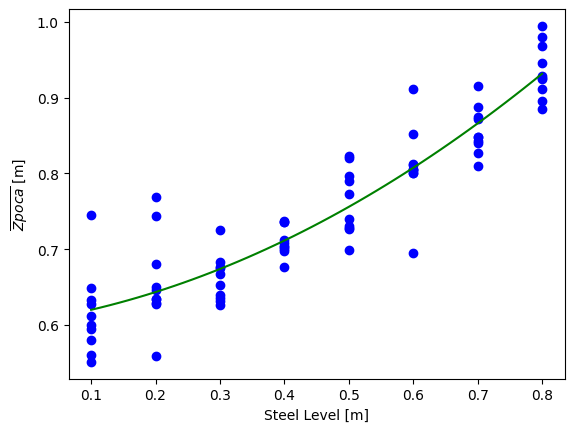

In [24]:
# Quadratic fit

plt.plot(Train_target, Train_in, "bo")

model = np.poly1d(np.polyfit(Train_target, Train_in, 2))

print("Residuals – sum of squared residuals of the least squares fit: " + str(round(np.polyfit(Train_target, Train_in, 2, full=True)[1][0], 4)))

polyline = np.linspace(min(Train_target), max(Train_target), 50)
plt.plot(polyline, model(polyline), "g")

plt.xlabel('Steel Level [m]')
plt.ylabel('$\overline{Zpoca}$ [m]')

print(model)

# x=0.7
# model[2]*x*x + model[1]*x + model[0]

Residuals – sum of squared residuals of the least squares fit: 0.1409668475538842
        2
0.3512 x + 0.1291 x + 0.6036


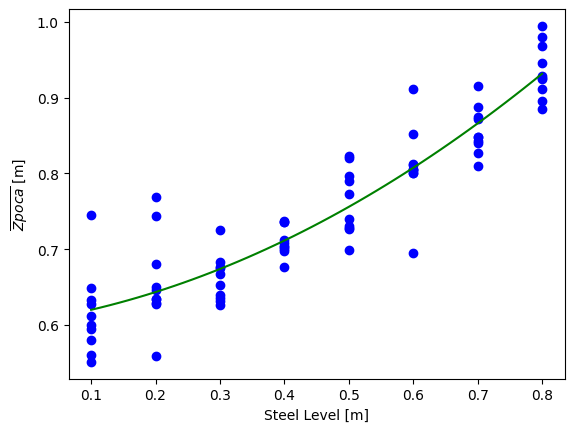

In [21]:
#define function to calculate r-squared
def polyfit(x, y, degree):
    results = {}
    coeffs = np.polyfit(x, y, degree)   # get coeefficients as numpy.ndarray
    p = np.poly1d(coeffs)
    
    #https://en.wikipedia.org/wiki/Coefficient_of_determination
    
    # calculate r-squared
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    
    ssreg = np.sum((yhat-ybar)**2)
    ssres = np.sum((y - yhat)**2)
    sstot = np.sum((y - ybar)**2)
    
    #results['r_squared'] = ssreg / sstot

    #return results
    
    # return ssreg / sstot # R squared for linear regression, as explaned variance
    return 1 - (ssres / sstot) # R squared for linear regression, as explaned variance ()

#find r-squared of polynomial model with degree = 2
# polyfit(Train_target, Train_in, 2)
# round(polyfit(Train_target, Train_in, 2), 3)

0.1
0.05245957701609264
0.2
0.0573691925554226
0.30000000000000004
0.028971762231217734
0.4
0.0188996518100055
0.5
0.041541844311338554
0.6000000000000001
0.050446900502068286
0.7000000000000001
0.02955386696488318
0.8
0.0342127943918815


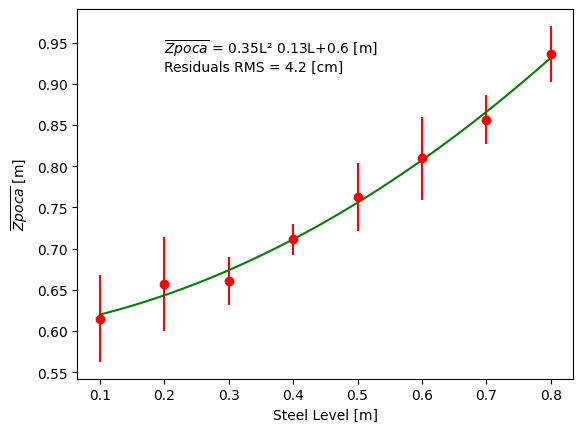

In [42]:
g_m = np.empty((np.unique(Train_target).shape[0], ))
g_m[:] = np.nan
g_sd = np.empty((np.unique(Train_target).shape[0], ))
g_sd[:] = np.nan

for i in range(0, np.unique(Train_target).shape[0]):
    print((np.unique(Train_target)[i]))
    g_m[i] = np.mean(Train_in[Train_target==(np.unique(Train_target)[i])])
    g_sd[i] = np.std(Train_in[Train_target==(np.unique(Train_target)[i])])
    #print(pred_1[TrueSteel==(np.unique(TrueSteel)[i])])
    
    print(g_sd[i])
    
g_m, g_sd



#np.savetxt(folder + "_Mean_PocaMeanZ_1.csv", [np.unique(TrueSteel), g_m], delimiter=",")
#np.savetxt(folder + "_SD_PocaMeanZ_1.csv", [np.unique(TrueSteel), g_sd], delimiter=",")


sigma = 1
# sigma = 3

#plt.plot(np.unique(TrueSteel), g_m, "bo")
#plt.errorbar(np.unique(TrueSteel), g_m, yerr=g_sd*2, fmt="o") # 2 sigma
plt.errorbar(np.unique(Train_target), g_m, yerr=g_sd*sigma, fmt="ro") # 3 sigma

plt.xlabel('Steel Level [m]')
plt.ylabel('$\overline{Zpoca}$ [m]')

#e = pred_1-TrueSteel
#m = np.mean(e)
#sd = np.std(e)
#rms = np.sqrt(np.mean(np.square(e)))

#plt.text(0.40, 0.69, ("mean = " + str(round(m*100, 2)) + " cm"))
#plt.text(0.40, 0.67, ("sd = " + str(round(sd*100, 2)) + " cm"))
#plt.text(0.40, 0.65, ("RMSE = " + str(round(rms*100, 2)) + " cm"))

MIN = min(Train_target)
MAX = max(Train_target)
#plt.plot( [MIN,MAX],[MIN,MAX] )

#plt.text(0.40, max(g_m), model)
plt.text(0.20, max(g_m), (  "$\overline{Zpoca}$ = "  +  str(round(model[2], 2))  + 'L² '  +  str(round(model[1], 2))  + 'L+'  +  str(round(model[0], 2)) + " [m]" ) )
#plt.text(0.40, max(g_m) - 0.005, (  str(round(model[2], 2))  + 'L² '  +  str(round(model[1], 2))  + 'L+'  +  str(round(model[0], 2))  ) )

# plt.text(0.40, max(g_m) - 0.01, (  "R² = " + str(round(polyfit(Train_target, Train_in, 2), 3))  ))

#plt.text(0.2, max(g_m) - 0.02, "Sum of squared residuals = " + str(round(np.polyfit(Train_target, Train_in, 2, full=True)[1][0], 4)))
plt.text(0.2, max(g_m) - 0.02, "Residuals RMS = " + str(round(np.sqrt(np.polyfit(Train_target, Train_in, 2, full=True)[1][0]/len(Train_in))*100, 2)) + " [cm]")


polyline = np.linspace(min(Train_target), max(Train_target), 50)
plt.plot(polyline, model(polyline), "g")

# plt.savefig(folder + 'PocaMeanZ_sigma_' + str(sigma) + '.png')

In [14]:
# Get training RMSE instead of R²

## **Testing built inference models**